### 📝 **Instructions to build the linear regression model in python**
#### US county-level sociodemographic and health resource data (2018-2019)
Sociodemographic and health resource data have been collected by county in the United States and we want to find out if there is any relationship between health resources and sociodemographic data.

To do this, you need to set a target variable (health-related) to conduct the analysis.

#### **Step 0: Import Libraries**

In [2]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# When you work locally it is likely to have an error with the SSL certification
# Recomend use request for read csv
import requests
from io import StringIO

from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (chi2,
                                       SelectKBest,
                                       f_regression)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV) # For Optimize
from sklearn.linear_model import (LogisticRegression,
                                  Lasso)
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            classification_report,
                            mean_squared_error,
                            r2_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Optimize
from pickle import dump

#### **Step 1: Loading the CSV into python dataset**
The dataset can be found in this project folder under the name `demographic_health_data.csv`. You can load it into the code directly from the link:

```text
https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv
```

Or download it and add it by hand in your repository. In this dataset you will find a large number of variables, which you will find defined [here](https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/data_dict.csv).

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")
df.head()

fips  TOT_POP    0-9  0-9 y/o % of total pop  19-Oct  \
0  1001    55601   6787               12.206615    7637   
1  1003   218022  24757               11.355276   26913   
2  1005    24881   2732               10.980266    2960   
3  1007    22400   2456               10.964286    2596   
4  1009    57840   7095               12.266598    7570   

   10-19 y/o % of total pop  20-29  20-29 y/o % of total pop  30-39  \
0                 13.735364   6878                 12.370281   7089   
1                 12.344167  23579                 10.814964  25213   
2                 11.896628   3268                 13.134520   3201   
3                 11.589286   3029                 13.522321   3113   
4                 13.087828   6742                 11.656293   6884   

   30-39 y/o % of total pop  ...  COPD_number  diabetes_prevalence  \
0                 12.749771  ...         3644                 12.9   
1                 11.564429  ...        14692                 12.0   
2                 12.865239  ...         2373                 19.7   
3                 13.897321  ...         1789                 14.1   
4                 11.901798  ...         4661                 13.5   

   diabetes_Lower 95% CI  diabetes_Upper 95% CI  diabetes_number  \
0                   11.9                   13.8             5462   
1                   11.0                   13.1            20520   
2                   18.6                   20.6             3870   
3                   13.2                   14.9             2511   
4                   12.6                   14.5             6017   

   CKD_prevalence  CKD_Lower 95% CI  CKD_Upper 95% CI  CKD_number  \
0             3.1               2.9               3.3        1326   
1             3.2               3.0               3.5        5479   
2             4.5               4.2               4.8         887   
3             3.3               3.1               3.6         595   
4             3.4               3.2               3.7        1507   

   Urban_rural_code  
0                 3  
1                 4  
2                 6  
3                 2  
4                 2  

[5 rows x 108 columns]

In [4]:
df['Heart disease_number']

0        3345
1       13414
2        2159
3        1533
4        4101
        ...  
3135     1862
3136      981
3137     1034
3138      500
3139      471
Name: Heart disease_number, Length: 3140, dtype: int64

In [5]:
# Create DB file. in. data./raw
df_raw = df.copy()
df_raw.to_csv("../data/raw/df_raw_RLR.csv", index= False)

In [6]:
display(df_raw.info())
display(df_raw.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


None

Index(['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop',
       ...
       'COPD_number', 'diabetes_prevalence', 'diabetes_Lower 95% CI',
       'diabetes_Upper 95% CI', 'diabetes_number', 'CKD_prevalence',
       'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number',
       'Urban_rural_code'],
      dtype='object', length=108)

#### **Select varaible for analysis**
Exploring the dataset we identified 5 variables that could help us perform the analysis. The chosen variable will be `Heart disease_prevalence` because studies indicate that these types of diseases are the main causes of mortality in many regions.

#### **Step 2: Perform a full EDA**
This second step is vital to ensure that we keep the variables that are strictly necessary and eliminate those that are not relevant or do not provide information. Use the example Notebook we worked on and adapt it to this use case.

Be sure to conveniently divide the data set into train and test as we have seen in previous lessons.

In [7]:
# Step 2.1: Preprocessing data
df_interim = (
    df_raw
        .copy()
        .set_axis(
            df_raw.columns.str.replace(' ','_')
                          .str.replace('r/W', '', regex= True)
                          .str.lower()
                          .str.slice(0, 40), axis= 1
        )
        .drop_duplicates().reset_index(drop= True)
)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


There are many columns, it is recommended to scale them and choose the variables with the greatest weight.There are many columns, it is recommended to scale them and choose the variables with the greatest weight

In [8]:
df_interim.rename(columns= {'heart_disease_number': 'target'}, inplace= True)
# Define the number columns without 'target'
data_types = df_interim.dtypes
num_columns = [c for c in list(data_types[data_types != "object"].index) if c != 'target']

# Apply StandardScaler only to numeric columns
scaler = StandardScaler()
norm_features = scaler.fit_transform(df_interim[num_columns])

# Create new DataFrame with scal number variables
df_interim_scal = pd.DataFrame(norm_features, index=df_interim.index, columns=num_columns)

# Insert column target
df_interim_scal['target'] = df_interim['target']

# Insert 'target' as the first column in df_interim_scal
df_interim_scal = df_interim_scal[['target'] + [col for col in df_interim_scal.columns if col != 'target']]

df_interim_scal.head()


target      fips   tot_pop       0-9  0-9_y/o_%_of_total_pop    19-oct  \
0    3345 -1.940874 -0.145679 -0.142421                0.158006 -0.135556   
1   13414 -1.940742  0.341296  0.287476               -0.242861  0.320383   
2    2159 -1.940610 -0.237785 -0.239429               -0.419441 -0.246181   
3    1533 -1.940478 -0.245223 -0.246032               -0.426966 -0.254791   
4    4101 -1.940346 -0.138966 -0.135053                0.186249 -0.137140   

   10-19_y/o_%_of_total_pop     20-29  20-29_y/o_%_of_total_pop     30-39  \
0                  0.573496 -0.153144                  0.027610 -0.139384   
1                 -0.193107  0.183774                 -0.469965  0.230620   
2                 -0.439718 -0.225971                  0.272104 -0.218759   
3                 -0.609076 -0.230792                  0.396168 -0.220555   
4                  0.216679 -0.155888                 -0.200808 -0.143570   

   ...  copd_number  diabetes_prevalence  diabetes_lower_95%_ci  \
0  ...    -0.138900            -0.063696              -0.071720   
1  ...     0.563986            -0.394103              -0.414900   
2  ...    -0.219763             2.432709               2.483064   
3  ...    -0.256918             0.376846               0.423984   
4  ...    -0.074198             0.156575               0.195197   

   diabetes_upper_95%_ci  diabetes_number  ckd_prevalence  ckd_lower_95%_ci  \
0              -0.089834        -0.129902       -0.609615         -0.582796   
1              -0.337677         0.376251       -0.433549         -0.393279   
2               2.317776        -0.183415        1.855312          1.880929   
3               0.299632        -0.229096       -0.257483         -0.203761   
4               0.158008        -0.111247       -0.081417         -0.014244   

   ckd_upper_95%_ci  ckd_number  urban_rural_code  
0         -0.669652   -0.147523         -1.082865  
1         -0.343373    0.389791         -0.420704  
2          1.777443   -0.204321          0.903618  
3         -0.180233   -0.242100         -1.745026  
4         -0.017093   -0.124105         -1.745026  

[5 rows x 106 columns]

In [9]:
# Create df_interim
df_interim_scal.to_csv("../data/interim/df_interim_RLR.csv")

In [10]:
# Make a copy from df_interim_scal
df = df_interim_scal.copy()

In [11]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state= 2024)

In [12]:
display(df_train.describe(include='number').T)

count         mean           std       min  \
target                  2512.0  5737.457006  16204.592599  7.000000   
fips                    2512.0    -0.005942      0.993040 -1.940874   
tot_pop                 2512.0     0.008918      1.044298 -0.312120   
0-9                     2512.0     0.007908      1.041848 -0.304787   
0-9_y/o_%_of_total_pop  2512.0     0.001053      0.995148 -5.589683   
...                        ...          ...           ...       ...   
ckd_prevalence          2512.0    -0.008313      1.003230 -2.898476   
ckd_lower_95%_ci        2512.0    -0.008661      1.004255 -2.857003   
ckd_upper_95%_ci        2512.0    -0.007936      1.002743 -2.953608   
ckd_number              2512.0     0.008131      1.041878 -0.318692   
urban_rural_code        2512.0    -0.006590      1.004843 -2.407187   

                               25%          50%          75%            max  
target                  800.500000  1832.000000  4443.250000  434790.000000  
fips                     -0.806775    -0.083419     0.966677       1.692838  
tot_pop                  -0.279472    -0.233937    -0.102344      29.986269  
0-9                      -0.274040    -0.230602    -0.104844      28.600342  
0-9_y/o_%_of_total_pop   -0.599294    -0.037893     0.504059       6.398903  
...                            ...          ...          ...            ...  
ckd_prevalence           -0.609615    -0.081417     0.622848       4.848438  
ckd_lower_95%_ci         -0.582796    -0.014244     0.554308       4.913206  
ckd_upper_95%_ci         -0.669652    -0.017093     0.635465       4.713958  
ckd_number               -0.278455    -0.224892    -0.085809      30.443001  
urban_rural_code         -1.082865     0.241457     0.903618       0.903618  

[106 rows x 8 columns]

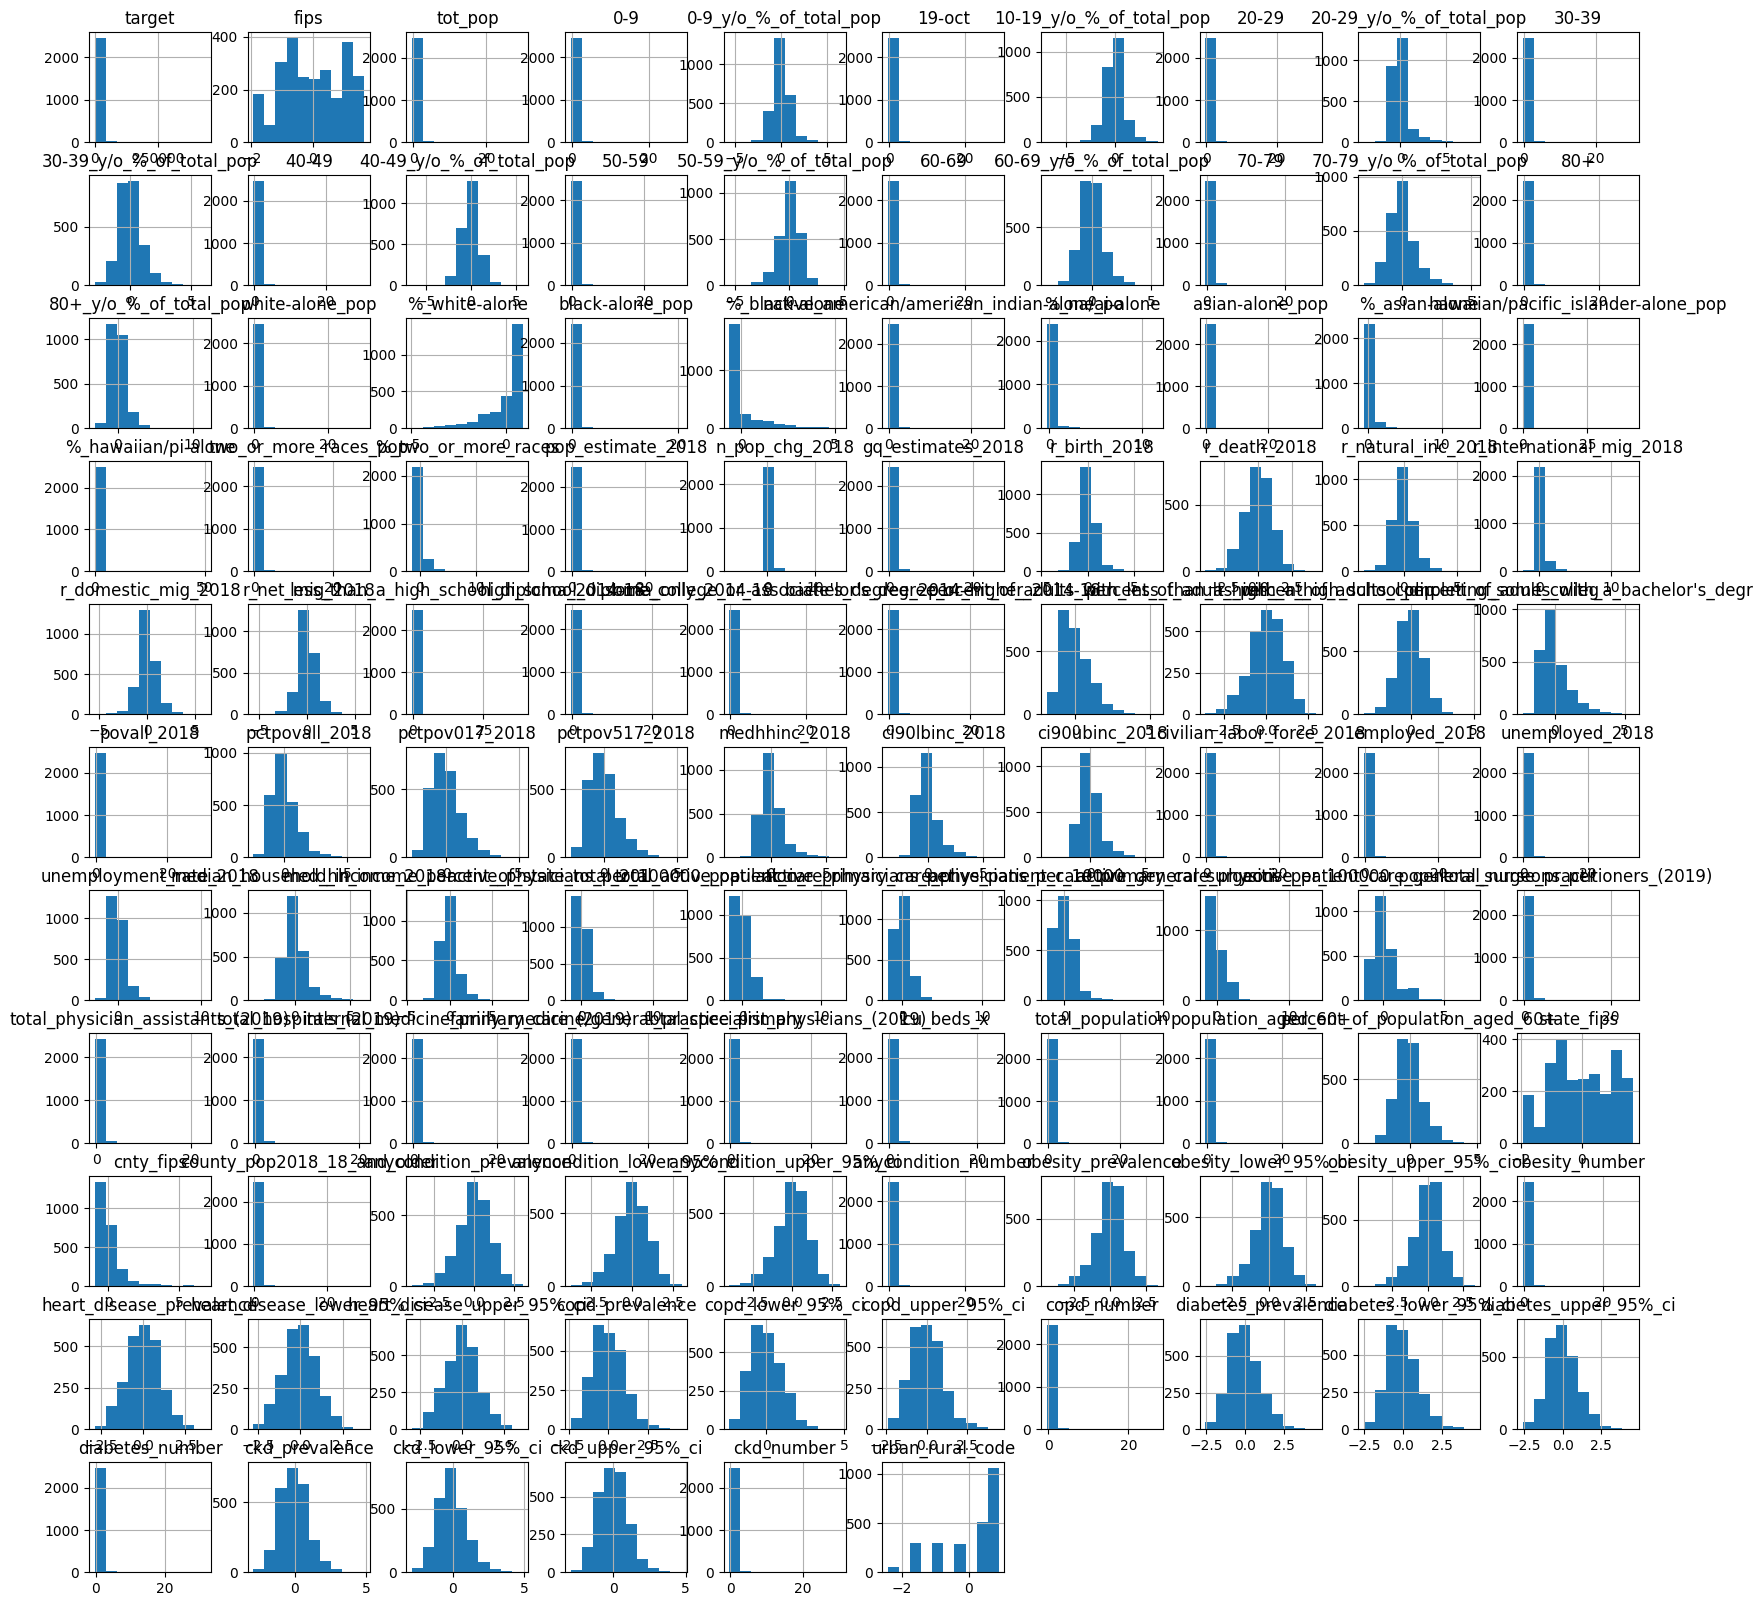

In [13]:
# Step 2.2: Univariate analysis
df_train.hist(figsize= (20, 20))
plt.show()

In [14]:
# Step 2.3: Bivariate analysis

# It will not be done because we have many variables, it is preferable to use SelectKBest() to analyze the variables that correspond

In [15]:
df_train.select_dtypes('number').corr()

target      fips   tot_pop       0-9  \
target                  1.000000 -0.061128  0.987234  0.977997   
fips                   -0.061128  1.000000 -0.057997 -0.051185   
tot_pop                 0.987234 -0.057997  1.000000  0.993848   
0-9                     0.977997 -0.051185  0.993848  1.000000   
0-9_y/o_%_of_total_pop  0.029389 -0.008119  0.047158  0.079451   
...                          ...       ...       ...       ...   
ckd_prevalence         -0.193107 -0.035352 -0.217696 -0.214367   
ckd_lower_95%_ci       -0.177813 -0.039697 -0.202214 -0.198859   
ckd_upper_95%_ci       -0.205217 -0.028494 -0.229938 -0.227621   
ckd_number              0.994913 -0.063266  0.993980  0.985347   
urban_rural_code       -0.439653  0.005779 -0.423785 -0.418668   

                        0-9_y/o_%_of_total_pop    19-oct  \
target                                0.029389  0.979466   
fips                                 -0.008119 -0.055187   
tot_pop                               0.047158  0.994903   
0-9                                   0.079451  0.997597   
0-9_y/o_%_of_total_pop                1.000000  0.068128   
...                                        ...       ...   
ckd_prevalence                       -0.107460 -0.225102   
ckd_lower_95%_ci                     -0.090452 -0.209376   
ckd_upper_95%_ci                     -0.128661 -0.238115   
ckd_number                            0.036294  0.985924   
urban_rural_code                     -0.034012 -0.426533   

                        10-19_y/o_%_of_total_pop     20-29  \
target                                 -0.002445  0.975739   
fips                                    0.008874 -0.056456   
tot_pop                                 0.017034  0.995060   
0-9                                     0.040968  0.990224   
0-9_y/o_%_of_total_pop                  0.687675  0.049663   
...                                          ...       ...   
ckd_prevalence                         -0.256650 -0.217835   
ckd_lower_95%_ci                       -0.239498 -0.202120   
ckd_upper_95%_ci                       -0.276620 -0.230529   
ckd_number                              0.002926  0.987663   
urban_rural_code                       -0.114412 -0.407035   

                        20-29_y/o_%_of_total_pop     30-39  ...  copd_number  \
target                                  0.148126  0.974643  ...     0.996857   
fips                                   -0.041600 -0.053874  ...    -0.063628   
tot_pop                                 0.156234  0.995631  ...     0.981089   
0-9                                     0.156909  0.991228  ...     0.972277   
0-9_y/o_%_of_total_pop                  0.120184  0.053427  ...     0.030945   
...                                          ...       ...  ...          ...   
ckd_prevalence                         -0.351821 -0.214072  ...    -0.193412   
ckd_lower_95%_ci                       -0.327219 -0.198718  ...    -0.177771   
ckd_upper_95%_ci                       -0.378949 -0.226404  ...    -0.205870   
ckd_number                              0.145927  0.986104  ...     0.990447   
urban_rural_code                       -0.231842 -0.408686  ...    -0.447707   

                        diabetes_prevalence  diabetes_lower_95%_ci  \
target                            -0.151545              -0.138447   
fips                              -0.026812              -0.031921   
tot_pop                           -0.173002              -0.159001   
0-9                               -0.164343              -0.149824   
0-9_y/o_%_of_total_pop            -0.004090               0.017766   
...                                     ...                    ...   
ckd_prevalence                     0.919587               0.909465   
ckd_lower_95%_ci                   0.925395               0.918592   
ckd_upper_95%_ci                   0.907943               0.894538   
ckd_number                        -0.143823              -0.130632   
urban_rural_code                   0

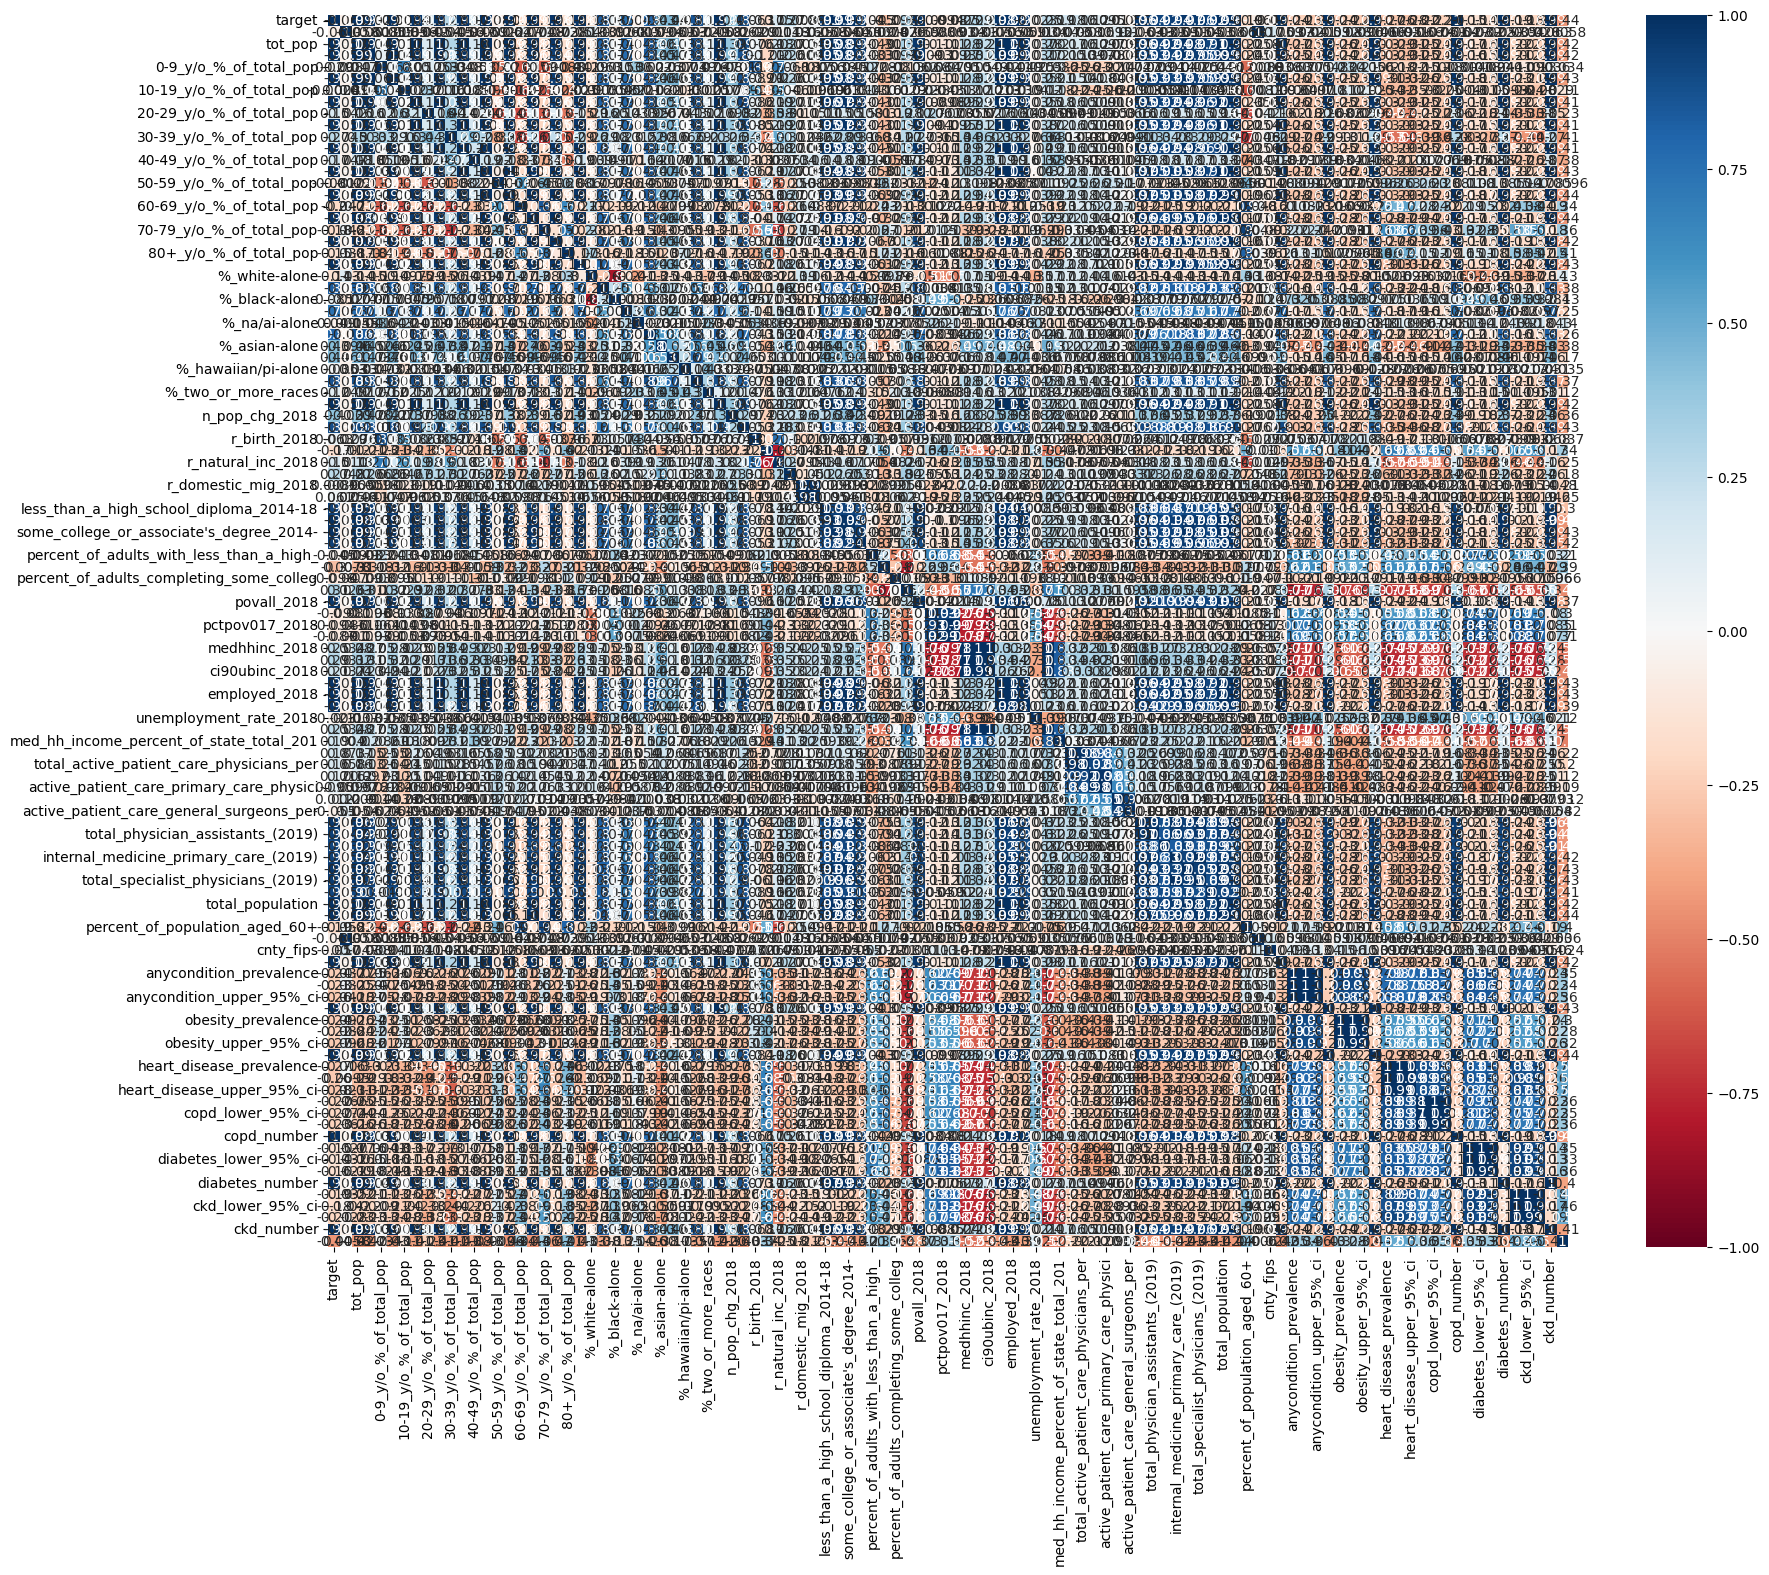

In [16]:
plt.figure(figsize= (20, 16))
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap= 'RdBu')
plt.show()

We note the difficulty of identifying the correlation between variables. Once again we recommend applying a selection of the variables with the greatest weight.

In [17]:
X_train = df_train.drop('target', axis=1).reset_index(drop= True)
y_train = df_train['target'].reset_index(drop= True)
X_test = df_test.drop('target', axis=1).reset_index(drop= True)
y_test = df_test['target'].reset_index(drop= True)

# Define the percentage of variables to select
k = int(len(X_train.columns) * 0.3)
selection_model = SelectKBest(score_func = f_regression, k = k) # Use f_regression for select characteristics for model
selection_model.fit(X_train, y_train) # Adjust model

# Select the index comlumns
ix = selection_model.get_support()

# Transform X_train and X_test to keep only the best features
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns[ix])

In [18]:
display(X_train_sel.head())
display(X_test_sel.head())

tot_pop       0-9    19-oct     20-29     30-39     40-49     50-59  \
0 -0.281868 -0.269740 -0.285588 -0.271926 -0.262468 -0.274546 -0.285927   
1 -0.275041 -0.265960 -0.276623 -0.263937 -0.254118 -0.263526 -0.278552   
2 -0.262205 -0.267084 -0.276954 -0.259943 -0.241767 -0.247881 -0.260876   
3 -0.216081 -0.205315 -0.209093 -0.221109 -0.208653 -0.218432 -0.221147   
4 -0.263695 -0.256774 -0.262266 -0.241948 -0.247646 -0.261869 -0.270452   

      60-69     70-79       80+  ...  \
0 -0.302935 -0.311833 -0.281842  ...   
1 -0.298618 -0.305030 -0.293946  ...   
2 -0.263935 -0.274317 -0.270401  ...   
3 -0.224443 -0.219446 -0.193050  ...   
4 -0.284623 -0.301973 -0.258877  ...   

   family_medicine/general_practice_primary  \
0                                 -0.283113   
1                                 -0.298656   
2                                 -0.263607   
3                                 -0.184939   
4                                 -0.238906   

   total_specialist_physicians_(2019)  total_population  population_aged_60+  \
0                           -0.281520         -0.279999            -0.298667   
1                           -0.282222         -0.272793            -0.298357   
2                           -0.274765         -0.262614            -0.272753   
3                           -0.230716         -0.209431            -0.205404   
4                           -0.272659         -0.261603            -0.284334   

   county_pop2018_18_and_older  anycondition_number  obesity_number  \
0                    -0.283179            -0.301387       -0.302332   
1                    -0.276250            -0.285892       -0.289438   
2                    -0.259301            -0.290979       -0.293911   
3                    -0.217928            -0.218076       -0.210236   
4                    -0.263599            -0.282848       -0.280896   

   copd_number  diabetes_number  ckd_number  
0    -0.335172        -0.285063   -0.287253  
1    -0.308769        -0.264827   -0.273280  
2    -0.311250        -0.266138   -0.263835  
3    -0.225680        -0.197802   -0.204968  
4    -0.319012        -0.269533   -0.271857  

[5 rows x 31 columns]

tot_pop       0-9    19-oct     20-29     30-39     40-49     50-59  \
0 -0.197710 -0.178593 -0.192087 -0.176182 -0.184992 -0.201246 -0.212742   
1 -0.233956 -0.229717 -0.241758 -0.237994 -0.223066 -0.232052 -0.238308   
2 -0.189822 -0.184478 -0.186670 -0.195610 -0.183767 -0.174788 -0.191157   
3 -0.276147 -0.272587 -0.280526 -0.264643 -0.257262 -0.261777 -0.281970   
4 -0.275230 -0.269190 -0.279769 -0.261920 -0.257282 -0.261846 -0.281057   

      60-69     70-79       80+  ...  \
0 -0.229339 -0.218313 -0.197610  ...   
1 -0.223400 -0.233201 -0.230358  ...   
2 -0.202770 -0.190508 -0.197776  ...   
3 -0.294098 -0.301185 -0.285822  ...   
4 -0.293982 -0.301382 -0.288972  ...   

   family_medicine/general_practice_primary  \
0                                 -0.168550   
1                                 -0.239170   
2                                 -0.220384   
3                                 -0.299682   
4                                 -0.298829   

   total_specialist_physicians_(2019)  total_population  population_aged_60+  \
0                           -0.224905         -0.194733            -0.212700   
1                           -0.246536         -0.232861            -0.228418   
2                           -0.195837         -0.188882            -0.194914   
3                           -0.274973         -0.274971            -0.290018   
4                           -0.282354         -0.273503            -0.292363   

   county_pop2018_18_and_older  anycondition_number  obesity_number  \
0                    -0.200499            -0.193974       -0.196201   
1                    -0.233724            -0.261416       -0.271253   
2                    -0.191578            -0.169821       -0.191111   
3                    -0.275964            -0.285265       -0.290311   
4                    -0.275453            -0.281998       -0.286269   

   copd_number  diabetes_number  ckd_number  
0    -0.211810        -0.197701   -0.199404  
1    -0.263979        -0.235483   -0.223340  
2    -0.113706        -0.152255   -0.166283  
3    -0.292863        -0.264155   -0.271986  
4    -0.307624        -0.258205   -0.270563  

[5 rows x 31 columns]

In [19]:
# Create DB to ../data/processed/
df_clean_train = X_train_sel
df_clean_test = X_test_sel
df_clean_train["target"] = list(y_train)
df_clean_test["target"] = list(y_test)
df_clean_train.to_csv("../data/processed/df_train_clean_RLR.csv", index = False)
df_clean_test.to_csv("../data/processed/df_test_clean_RLR.csv", index = False)

#### **Step 3: Build a linear regression model in python**
Start solving the problem by implementing a linear regression model and analyze the results. Then, using the same data and default attributes, build a Lasso model and compare the results with the baseline linear regression.

Analyze how R^2 evolves when the hyperparameter of the Lasso model changes (you can, for example, start testing from a value of 0.0 and work your way up to a value of 20). Draw these values in a line diagram.

In [28]:
df_train = pd.read_csv("../data/processed/df_train_clean_RLR.csv")
df_test = pd.read_csv("../data/processed/df_train_clean_RLR.csv")

display(df_train.head())
display(df_test.head())

tot_pop       0-9    19-oct     20-29     30-39     40-49     50-59  \
0 -0.281868 -0.269740 -0.285588 -0.271926 -0.262468 -0.274546 -0.285927   
1 -0.275041 -0.265960 -0.276623 -0.263937 -0.254118 -0.263526 -0.278552   
2 -0.262205 -0.267084 -0.276954 -0.259943 -0.241767 -0.247881 -0.260876   
3 -0.216081 -0.205315 -0.209093 -0.221109 -0.208653 -0.218432 -0.221147   
4 -0.263695 -0.256774 -0.262266 -0.241948 -0.247646 -0.261869 -0.270452   

      60-69     70-79       80+  ...  total_specialist_physicians_(2019)  \
0 -0.302935 -0.311833 -0.281842  ...                           -0.281520   
1 -0.298618 -0.305030 -0.293946  ...                           -0.282222   
2 -0.263935 -0.274317 -0.270401  ...                           -0.274765   
3 -0.224443 -0.219446 -0.193050  ...                           -0.230716   
4 -0.284623 -0.301973 -0.258877  ...                           -0.272659   

   total_population  population_aged_60+  county_pop2018_18_and_older  \
0         -0.279999            -0.298667                    -0.283179   
1         -0.272793            -0.298357                    -0.276250   
2         -0.262614            -0.272753                    -0.259301   
3         -0.209431            -0.205404                    -0.217928   
4         -0.261603            -0.284334                    -0.263599   

   anycondition_number  obesity_number  copd_number  diabetes_number  \
0            -0.301387       -0.302332    -0.335172        -0.285063   
1            -0.285892       -0.289438    -0.308769        -0.264827   
2            -0.290979       -0.293911    -0.311250        -0.266138   
3            -0.218076       -0.210236    -0.225680        -0.197802   
4            -0.282848       -0.280896    -0.319012        -0.269533   

   ckd_number  target  
0   -0.287253     622  
1   -0.273280     881  
2   -0.263835    1030  
3   -0.204968    2176  
4   -0.271857     924  

[5 rows x 32 columns]

tot_pop       0-9    19-oct     20-29     30-39     40-49     50-59  \
0 -0.281868 -0.269740 -0.285588 -0.271926 -0.262468 -0.274546 -0.285927   
1 -0.275041 -0.265960 -0.276623 -0.263937 -0.254118 -0.263526 -0.278552   
2 -0.262205 -0.267084 -0.276954 -0.259943 -0.241767 -0.247881 -0.260876   
3 -0.216081 -0.205315 -0.209093 -0.221109 -0.208653 -0.218432 -0.221147   
4 -0.263695 -0.256774 -0.262266 -0.241948 -0.247646 -0.261869 -0.270452   

      60-69     70-79       80+  ...  total_specialist_physicians_(2019)  \
0 -0.302935 -0.311833 -0.281842  ...                           -0.281520   
1 -0.298618 -0.305030 -0.293946  ...                           -0.282222   
2 -0.263935 -0.274317 -0.270401  ...                           -0.274765   
3 -0.224443 -0.219446 -0.193050  ...                           -0.230716   
4 -0.284623 -0.301973 -0.258877  ...                           -0.272659   

   total_population  population_aged_60+  county_pop2018_18_and_older  \
0         -0.279999            -0.298667                    -0.283179   
1         -0.272793            -0.298357                    -0.276250   
2         -0.262614            -0.272753                    -0.259301   
3         -0.209431            -0.205404                    -0.217928   
4         -0.261603            -0.284334                    -0.263599   

   anycondition_number  obesity_number  copd_number  diabetes_number  \
0            -0.301387       -0.302332    -0.335172        -0.285063   
1            -0.285892       -0.289438    -0.308769        -0.264827   
2            -0.290979       -0.293911    -0.311250        -0.266138   
3            -0.218076       -0.210236    -0.225680        -0.197802   
4            -0.282848       -0.280896    -0.319012        -0.269533   

   ckd_number  target  
0   -0.287253     622  
1   -0.273280     881  
2   -0.263835    1030  
3   -0.204968    2176  
4   -0.271857     924  

[5 rows x 32 columns]

In [30]:
X_train = df_train.drop('target', axis=1).reset_index(drop= True)
y_train = df_train['target'].reset_index(drop= True)
X_test = df_test.drop('target', axis=1).reset_index(drop= True)
y_test = df_test['target'].reset_index(drop= True)

In [31]:
# Create the model
clf_rlr = LogisticRegression()

# Train model
clf_rlr.fit(X_train, y_train)

/workspaces/machine_lerning_project_regularized_linear-regression/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
# Predictions
y_pred = clf_rlr.predict(X_test)

In [33]:
y_pred

array([1050, 1050, 1050, ..., 1050, 1050, 1050])

In [34]:
print(f"Intercep (a): {clf_rlr.intercept_}")
print(f"Coefficients: {clf_rlr.coef_}")

Intercep (a): [-0.34167975 -0.34205296 -0.33819209 ... -2.2113287  -2.30620629
 -2.25039114]
Coefficients: [[-0.07262053 -0.06770616 -0.07461278 ... -0.12098927 -0.08452989
  -0.08508305]
 [-0.07276516 -0.06838146 -0.07527683 ... -0.12098556 -0.08439072
  -0.08473013]
 [-0.07221995 -0.06745512 -0.07416271 ... -0.12058771 -0.08418167
  -0.08457014]
 ...
 [ 0.23923108  0.42199183  0.26823441 ...  0.04900048  0.57295239
   0.13006238]
 [ 0.20224323  0.170112    0.12123989 ...  0.25389167  0.11925277
   0.31832908]
 [ 0.23771227  0.14389492  0.15407311 ...  0.06454295  0.39654263
   0.29437124]]


In [38]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

MSE: 6035568.517914013
R2 Score: 0.9770059816744283


#### **Step 4: Optimize the previous linear regression model using python**
After training the Lasso model, if the results are not satisfactory, optimize it using one of the techniques seen above.

In [37]:
alpha = 1.0
lasso_model = Lasso(alpha = alpha)

# Training the model
lasso_model.fit(X_train, y_train)

# We evaluate the performance of the model on the test data
score = lasso_model.score(X_test, y_test)
print("Coefficients:", lasso_model.coef_)
print("R2 score:", score)

Coefficients: [ 4278.056945    1893.84991505 -2384.1104407   -834.31828085
  -907.2738787   3653.3544555   1376.07678464 -1346.72798971
  3933.820522     925.01004945  1029.11099189 -5367.08751509
   -20.87463036  -829.60171494  -295.03666088  2570.91391627
   425.68659162    29.5404282  -1629.47508152   123.84750622
   464.47545783  -343.98993849  -880.06955142 -2877.2614723
  3094.76109344   150.85642036  1938.48632696  2939.69691358
  5307.11517542   505.79666908 -1170.88501683]
R2 score: 0.9989903222356423
Accuracy_score: 0.06329617834394904


/workspaces/machine_lerning_project_regularized_linear-regression/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.192e+08, tolerance: 6.594e+07
  model = cd_fast.enet_coordinate_descent(


In [26]:
dump(lasso_model, open("../models/lasso_alpha-1.0.sav", "wb"))